# CH3.CNN
AlexNet을 직접 구현해 CIFAR10데이터에 적용 해본다.

이 실습을 통해 기본적인 Pytorch의 학습 방식과 AlexNet 모델의 구조를 직접 구축해볼 수 있다.

### Content
1. 필요한 패키지 불러오기 및 parameter 구성하기
2. CIFAR10 데이터 가져오기
3. Trainloader 이미지 살펴보기
4. AlexNet 모델 정의
5. 모델 학습
6. 모델 검증

### Reference
* https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://github.com/icpm/pytorch-cifar10/blob/master/models/AlexNet.py

## 1. 필요한 패키지 불러오기 및 parameter 구성하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time, datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 32,
          'worker'      : 2,
          'epochs'      : 5,
          'momentum'    : 0.9,
          'lr_decay'    : 0.0005,
          'SGD_lr'      : 0.01,
          'Adam_lr'     : 0.001,
          }

cuda


## 2. CIFAR10데이터 가져오기
CIFAR10 데이터는 총 60,000장(클래스당 6,000장)의 이미지를 가지고 있으며 이중 50,000장은 train image, 10,000장은 test image로 사용된다.
(https://www.cs.toronto.edu/~kriz/cifar.html)
![CIFAR-10](https://user-images.githubusercontent.com/79437139/128126531-b9c51860-cc9e-4486-b83b-d892588a7f17.jpg)


일반적으로 이미지나 텍스트, 오디오, 비디오 데이터를 다룰 때는 표준 Python패키지를 이용해 Numpy배열로 불러온다. Pytorch에서는 그 배열을 `torch.*Tensor`로 변환한다.
* 이미지: Pillow, OpenCV, Matplotlib
* 오디오: SciPy, LibROSA
* 텍스트: 일반 Python, Cython, NLTK, SpaCy

Pytorch에서는 영상분야를 위한 `torchvision` 패키지가 있는데 여기서 Imagenet, CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 data loader, 즉 `torchvision.datasets`과 이미지용 데이터변환기(data transformer) 즉, `torch.utils.data.DataLoader`가 포함되어 있다.

여기서는 `torchvision`을 사용하여 CIFAR10의 Train/Test 데이터셋을 불러오고 정규화를 적용해준다.


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256), # 256 x 256 픽셀 이미지로 크기 변경
    transforms.CenterCrop(227), # 중앙에서 227x227 픽셀 이미지로 이미지 자르기
    transforms.RandomHorizontalFlip(), # 무작위로 수평으로 뒤집기
    transforms.ToTensor(), # 이미지를 텐서로 변환
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# CIFAR10 data download 
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = train_transforms)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = test_transforms)
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")

# DatsLoader를 이용하여 Dataset의 batch처리, 병렬처리, 이미지 순서 재배치
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

Files already downloaded and verified
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. trainloader 이미지 살펴보기

CIFAR10데이터 가져오기에서 만든 trainloader에 이미지가 어떻게 저장되어있는지 이미지와 라벨을 같이 확인해본다.

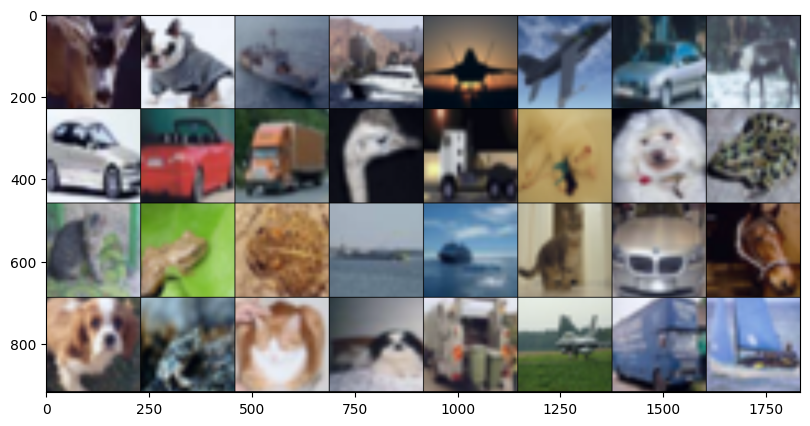

1: deer  	2: dog  	3: ship  	4: ship  	5: airplane	6: airplane	7: automobile	8: deer
9: automobile	10: automobile	11: truck  	12: bird  	13: truck  	14: cat  	15: dog  	16: frog
17: cat  	18: frog  	19: frog  	20: ship  	21: ship  	22: cat  	23: automobile	24: horse
25: dog  	26: frog  	27: cat  	28: dog  	29: truck  	30: airplane	31: truck  	32: ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2,0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

## 4. AlexNet 모델 정의
AlexNet 모델을 직접 구축해보자
![image](https://user-images.githubusercontent.com/79437139/128139491-40b3048d-288c-4bb5-8ff9-507ebdef654d.png)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()

        
        self.net = nn.Sequential(
            
            nn.Conv2d(in_channels = 3, out_channels= 96, kernel_size = 11, stride = 4, padding = 0), # [227 x 227 x 3] INPUT --> [55 x 55 x 96]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2), # [55 x 55 x 96] --> [27 x 27 x 96]
            nn.LocalResponseNorm(size = 5, alpha = 0.001, beta = 0.75, k = 2), # Normalization layer
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2), # [27 x 27 x 96] --> [27 x 27 x 256]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2), # [27 x 27 x 256] --> [13 x 13 x 256]
            nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75, k = 2), # Normalization layer

            nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1), # [13 x 13 x 256] --> [13 x 13 x 384]
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1), # [13 x 13 x 384] --> [13 x 13 x 256]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2), # [13 x 13 x 256] --> [6 x 6 x 256]
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(in_features = (6 * 6 * 256), out_features = 4096), #4096 neurons
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU(),
            nn.Linear(in_features = 4096, out_features = num_classes),
        )
      
    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 6 * 6 * 256) # flatten
        x = self.classifier(x)
        return x

In [ ]:
# 모델 확인
model = AlexNet()
model = model.to(device)
summary(model, (3,227,227), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
 LocalResponseNorm-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
 LocalResponseNorm-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

## 5. 모델 학습

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = config['Adam_lr'])
optimizer = optim.SGD(params=model.parameters(), lr = config['SGD_lr'], momentum= config['momentum'], weight_decay=config['lr_decay'])

In [ ]:
for epoch in range(config['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #Time
        end_time = time.time()
        duration = str(datetime.timedelta(seconds=time.time() - start_time)).split('.')[0]
       
    print('Epoch: {}/{}, train_loss: {:.4f}, time:{}'.format(epoch + 1, config['epochs'], running_loss / len(trainset), duration))
       

print('Finished Training of AlexNet')

Epoch: 1/5, train_loss: 0.0573, time:0:01:54
Epoch: 2/5, train_loss: 0.0394, time:0:01:49
Epoch: 3/5, train_loss: 0.0308, time:0:01:52
Epoch: 4/5, train_loss: 0.0263, time:0:01:49
Epoch: 5/5, train_loss: 0.0233, time:0:01:51
Finished Training of AlexNet


## 6. 모델 검증

In [ ]:
# Testloader 전체의 정확도
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 74.26 %


In [ ]:
# 각 class 별 정확도
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes_name[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 85 %
Accuracy of automobile : 93 %
Accuracy of  bird : 55 %
Accuracy of   cat : 38 %
Accuracy of  deer : 81 %
Accuracy of   dog : 75 %
Accuracy of  frog : 80 %
Accuracy of horse : 83 %
Accuracy of  ship : 76 %
Accuracy of truck : 80 %
